# [The Curse of Conditions: Analyzing and Improving Optimal Transport for Conditional Flow-Based Generation](https://hkchengrex.github.io/C2OT)

[arXiv](https://arxiv.org/abs/2503.10636)

In this notebook, we compare conditional flow matching (CFM -- referred to simply as FM here to avoid confusion with the "target condition" which is what we care about) with independent coupling, FM with optimal transport (OT), and our formulation "conditional optimal transport", or C<sup>2</sup>OT.
We use the 8 Gaussians -> moons dataset in the conditional setting. 

Through this notebook, we will introduce the motivation behind C<sup>2</sup>OT, and demonstrate its effectiveness.

In [1]:
# import common libraries
import os

import numpy as np
import torch
from torch import optim
from torch.utils.data import Dataset

from c2ot.ot import OTConditionalPlanSampler
from c2ot.utils.playground_utils import *

In [2]:
# hyperparameters
total_iter = 5000
batch_size = 256
ot_batch_size = 256
vis_batch_size = 1024
vis_num_points = 1000

## First, let us visualize the prior and the target distributions

In [3]:
import matplotlib.pyplot as plt

dataset = EightGaussianToMoons(ot_batch_size, condition_type='cls')
x0, x1, y1 = dataset[0]

### The prior distribution
The prior distribution is a mixture of 8 Gaussians.

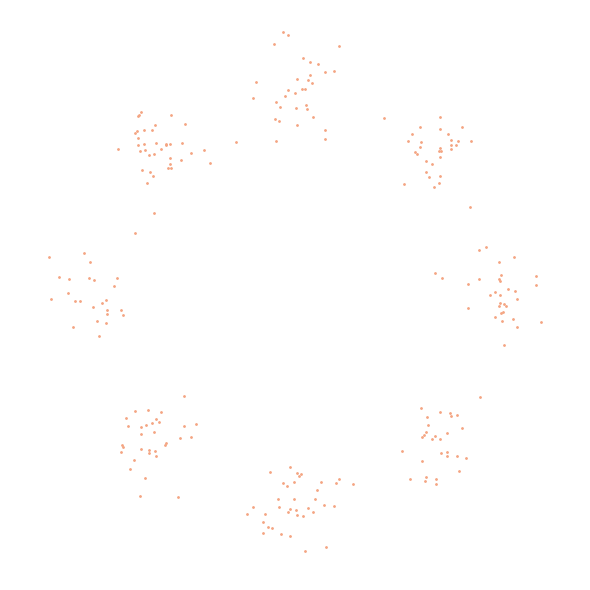

In [4]:
plt.figure(figsize=(6, 6))
plt.xlim(-7, 7)
plt.ylim(-7, 7)
plt.scatter(x0[:, 0], x0[:, 1], c='#F4A582', s=1)
plt.xticks([])
plt.yticks([])
plt.gca().set_frame_on(False)
plt.tight_layout()
plt.show()

### The target distribution
The target distribution consists of 2 moons. In this notebook, we assume a class label is given, ie, which half of the moon the sample belongs to. We visualize the condition as the color of the samples.

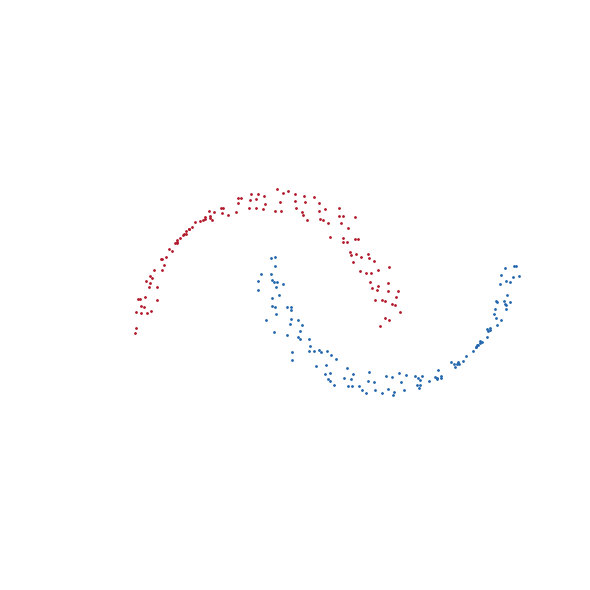

In [5]:
plt.figure(figsize=(6, 6))
plt.xlim(-7, 7)
plt.ylim(-7, 7)
plt.scatter(x1[y1[:,0]<0, 0], x1[y1[:,0]<0, 1], c='#B2182B', s=1)
plt.scatter(x1[y1[:,0]>0, 0], x1[y1[:,0]>0, 1], c='#2166AC', s=1)
plt.xticks([])
plt.yticks([])
plt.gca().set_frame_on(False)
plt.tight_layout()
plt.show()

## Then, let's see how different algorithms couple samples from the prior and the target distributions

### Conditional Flow Matching (FM)

With FM, we couple a random sample from the prior with a random sample from the data. We color (indicating the condition) the corresponding samples with similar colors.

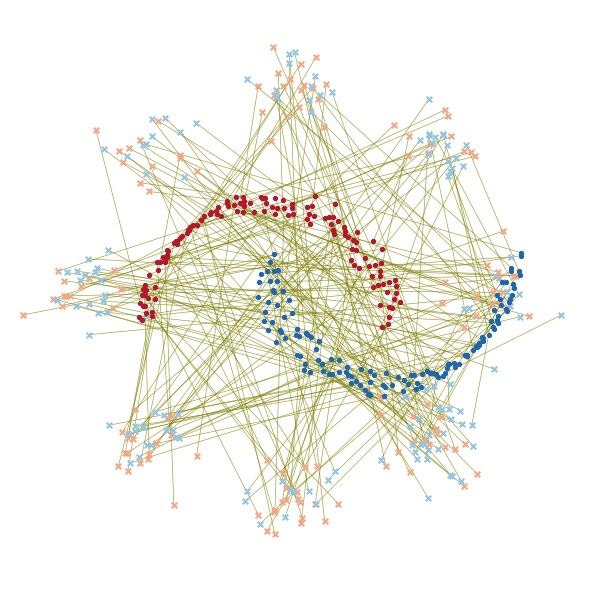

In [6]:
dataset = EightGaussianToMoons(ot_batch_size, condition_type='cls')
x0, x1, y1 = dataset[0]

traj = np.stack([x0, x1], axis=0)
vis_trajectories_colored(traj, y1)

Note that the paths are somewhat random and chaotic -- this leads to curved flows that are difficult to numerically integrate at test time.

### Minibatch Optimal Transport Conditional Flow Matching (OT)

With OT, we couple samples from the prior and the target distributions by solving an optimal transport problem, with the transport cost being the squared Euclidean distance between samples.

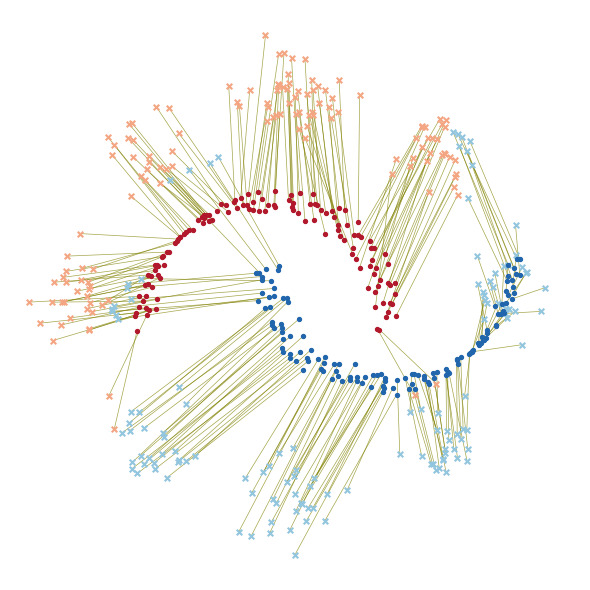

In [7]:
ot_planner = OTConditionalPlanSampler()
dataset = EightGaussianToMoons(ot_batch_size, condition_type='cls', ot_planner=ot_planner)
x0, x1, y1 = dataset[0]

traj = np.stack([x0, x1], axis=0)
vis_trajectories_colored(traj, y1)

Note the paths are much more "organized" -- which is great because we obtain straighter flows that are easier to integrate at test time.
However, also note that the correlation between the prior and the condition is now different. If we know the coordinate of a sampled prior during training, we can make a pretty good guess as to which condition it belongs to. That is, $q(x_0)$ and $q(x_0 | c)$ are not the same, where $x_0$ is the prior distribution and $c$ is the condition.

This is problematic because we cannot sample from $q(x_0 | c)$ during test time -- it is uniquely induced by OT couplings (which has access to the ground-truth target samples). Instead, we can only sample from $q(x_0)$, which is the full prior distribution. This discrepancy between training and test time leads to degeneration -- imagine if we can sample a point with the red condition from the bottom Gaussian! The model has never seen such a sample during training.

### Conditional Optimal Transport Conditional Flow Matching (C<sup>2</sup>OT)

Our contribution is to *unskew* the prior distribution during training, by forcing $q(x_0 | c)=q(x_0)$. Simply put, we add a conditional distance term to the transport cost. In the extreme case, we can set the weighting for this term to be infinity which effectively means that OT is performed independently for each condition. 

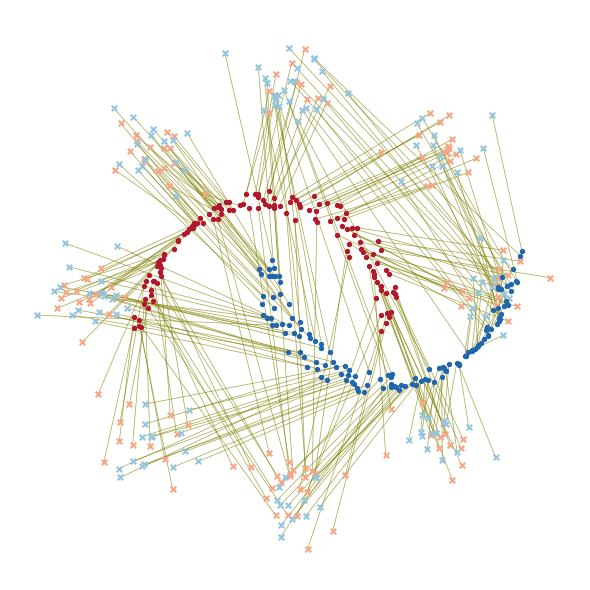

In [8]:
ot_planner = OTConditionalPlanSampler(condition_weight=1e8, condition_norm='cosine')
dataset = EightGaussianToMoons(ot_batch_size, condition_type='cls', ot_planner=ot_planner)
x0, x1, y1 = dataset[0]

traj = np.stack([x0, x1], axis=0)
vis_trajectories_colored(traj, y1)

Note that the distribution of the prior is now "unbiased", ie, the same as in the FM case. However, the paths are still somewhat organized, which is great for test-time integration.

## Training these models

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [10]:
def train(fm_type: str):

    model = ConditionalNet(in_dim=2, dim=128, depth=3).to(device)
    optimizer = optim.Adam(model.parameters(), lr=3e-4, fused=True)

    if fm_type == 'fm':
        ot_planner = None
    elif fm_type == 'ot':
        ot_planner = OTConditionalPlanSampler()
    elif fm_type == 'c2ot':
        ot_planner = OTConditionalPlanSampler(condition_weight=1e8, condition_norm='cosine')

    dataset = EightGaussianToMoons(ot_batch_size, 'cls', ot_planner)
    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=None,
                                             shuffle=False,
                                             num_workers=4)

    # print the number of parameters
    num_params = sum(p.numel() for p in model.parameters())
    print(f'Number of parameters: {num_params/1e3:.2f}K')

    k = 0
    for x0, x1, y1 in dataloader:

        x0 = x0.to(device)
        x1 = x1.to(device)
        y1 = y1.to(device) if y1 is not None else None

        x0_full_batch = x0
        x1_full_batch = x1
        y1_full_batch = y1

        for i in range(0, ot_batch_size, batch_size):
            optimizer.zero_grad(set_to_none=True)
            x0 = x0_full_batch[i:i + batch_size]
            x1 = x1_full_batch[i:i + batch_size]
            y1 = y1_full_batch[i:i + batch_size] if y1_full_batch is not None else None

            t = torch.rand(x0.shape[0], device=x0.device, dtype=x0.dtype)

            xt = sample_conditional_pt(x0, x1, t)
            ut = compute_conditional_vector_field(x0, x1)

            vt = model(xt, y1, t[:, None])
            loss = F.mse_loss(vt, ut)

            loss.backward()
            optimizer.step()

            k += 1

            if k >= total_iter:
                break
        if k >= total_iter:
            break

    # visualize the learned flows
    x0 = sample_8gaussians(vis_batch_size).to(device)
    x1, cls_labels = sample_moons(vis_batch_size)
    x1 = x1.to(device)
    y1 = cls_labels.to(device).unsqueeze(-1).float() * 2 - 1
    traj, _ = integrate(model,
                        x0,
                        'dopri5',
                        vis_num_points,
                        condition=y1,
                        num_points=vis_num_points)
    vis_trajectories_colored(traj, y1)

    traj, _ = integrate(model, x0, 'euler', 1, condition=y1, num_points=vis_num_points)
    vis_trajectories_colored(traj, y1)

### Visualize the learned flows by FM (with an adaptive solver and with the single-step Euler method)

Number of parameters: 396.29K


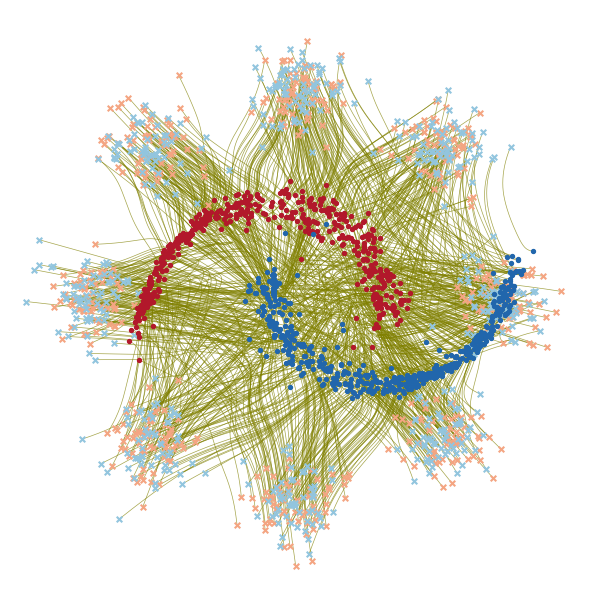

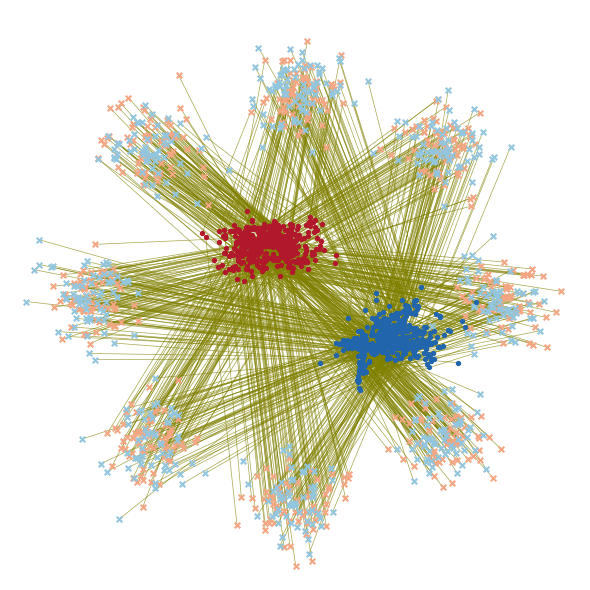

In [11]:
train('fm')

Note that FM works with the adaptive solver which can navigate through the curved flows. However, FM collapses with the single-step Euler method, as the learned flow approximately learns the mean of the conditional target distribution.

### Visualize the learned flows by OT (with an adaptive solver and with the single-step Euler method)

Number of parameters: 396.29K


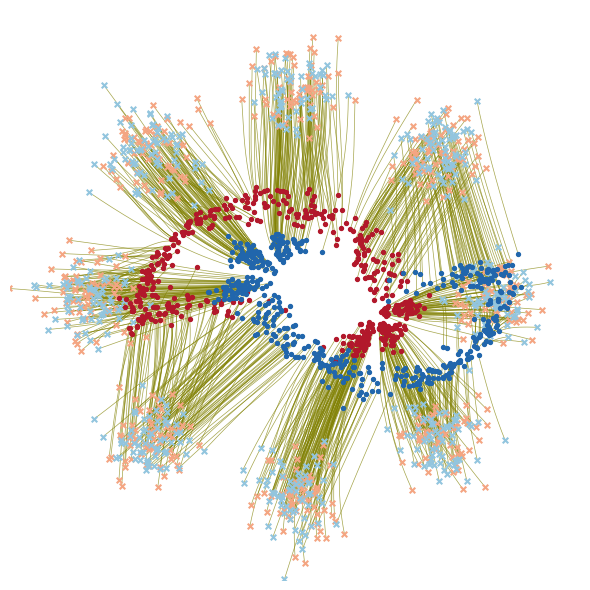

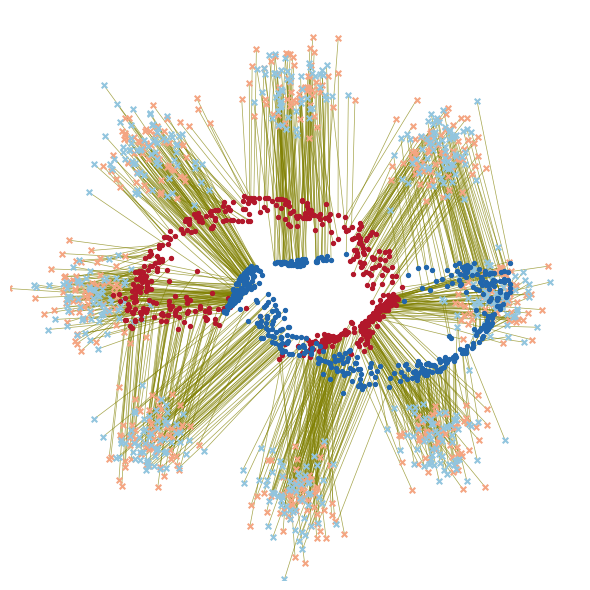

In [12]:
train('ot')

Note that OT fails to capture the target distribution because of the aforementioned discrepancy between training and testing. 

### Visualize the learned flows by our method C<sup>2</sup>OT (with an adaptive solver and with the single-step Euler method)

Number of parameters: 396.29K


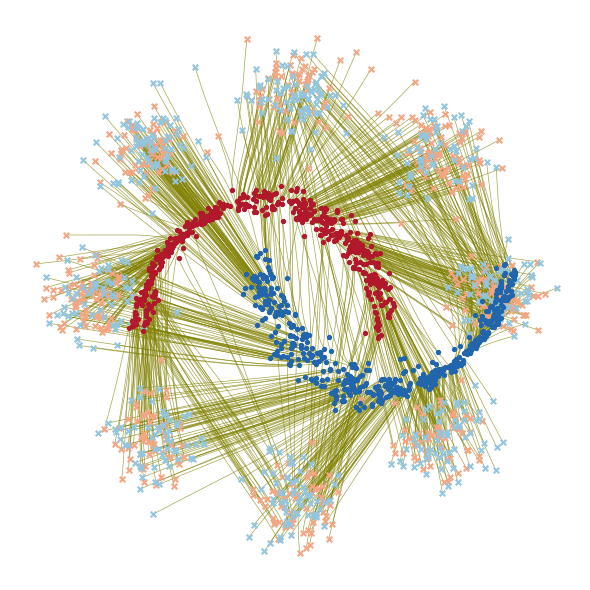

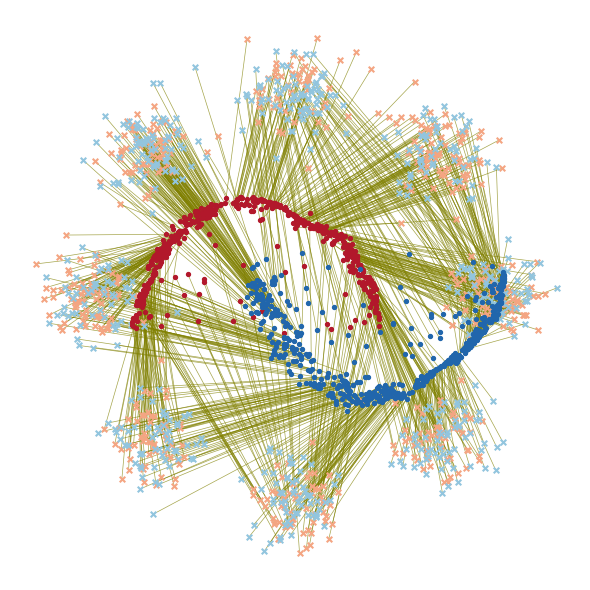

In [13]:
train('c2ot')

Our method successfully captures the target distribution. Additionally, our method works decently well even with a single Euler integration step as the learned flow is relatively straight and easy to integrate.

# With Continuous Conditions
A lot of real-world conditions are continuous, such as embedded features of a captions in text-to-image models. In this section, we will show that our method can also be applied to continuous conditions.
We will use the same 8 Gaussians -> moons dataset, but we will use the x coordinate of the target distribution as the condition. 

In [23]:
# hyperparameters
total_iter = 20000
batch_size = 256
ot_batch_size = 1024
vis_batch_size = 1024
vis_num_points = 1000

In [24]:
def train_continuous(fm_type: str):

    model = ConditionalNet(in_dim=2, dim=128, depth=3).to(device)
    optimizer = optim.Adam(model.parameters(), lr=3e-4, fused=True)

    if fm_type == 'fm':
        ot_planner = None
    elif fm_type == 'ot':
        ot_planner = OTConditionalPlanSampler()
    elif fm_type == 'c2ot':
        ot_planner = OTConditionalPlanSampler(condition_weight=100, # initial value
        target_r=0.01, # target "r", see Equation (13) of the paper
        condition_norm='l2_squared')

    dataset = EightGaussianToMoons(ot_batch_size, 'x', ot_planner)
    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=None,
                                             shuffle=False,
                                             num_workers=4)

    # print the number of parameters
    num_params = sum(p.numel() for p in model.parameters())
    print(f'Number of parameters: {num_params/1e3:.2f}K')

    k = 0
    for x0, x1, y1 in dataloader:

        x0 = x0.to(device)
        x1 = x1.to(device)
        y1 = y1.to(device) if y1 is not None else None

        x0_full_batch = x0
        x1_full_batch = x1
        y1_full_batch = y1

        for i in range(0, ot_batch_size, batch_size):
            optimizer.zero_grad(set_to_none=True)
            x0 = x0_full_batch[i:i + batch_size]
            x1 = x1_full_batch[i:i + batch_size]
            y1 = y1_full_batch[i:i + batch_size] if y1_full_batch is not None else None

            t = torch.rand(x0.shape[0], device=x0.device, dtype=x0.dtype)

            xt = sample_conditional_pt(x0, x1, t)
            ut = compute_conditional_vector_field(x0, x1)

            vt = model(xt, y1, t[:, None])
            loss = F.mse_loss(vt, ut)

            loss.backward()
            optimizer.step()

            k += 1

            if k >= total_iter:
                break
        if k >= total_iter:
            break

    # visualize the learned flows
    x0 = sample_8gaussians(vis_batch_size).to(device)
    x1, _ = sample_moons(vis_batch_size)
    x1 = x1.to(device)
    y1 = x1[:, 0:1].to(device).float() # extract the x-coordinate as condition
    traj, _ = integrate(model,
                        x0,
                        'dopri5',
                        vis_num_points,
                        condition=y1,
                        num_points=vis_num_points)
    vis_trajectories_colored(traj, y1)

    traj, _ = integrate(model, x0, 'euler', 1, condition=y1, num_points=vis_num_points)
    vis_trajectories_colored(traj, y1)

### Visualize the learned flows by FM (with an adaptive solver and with the single-step Euler method)

Number of parameters: 396.29K


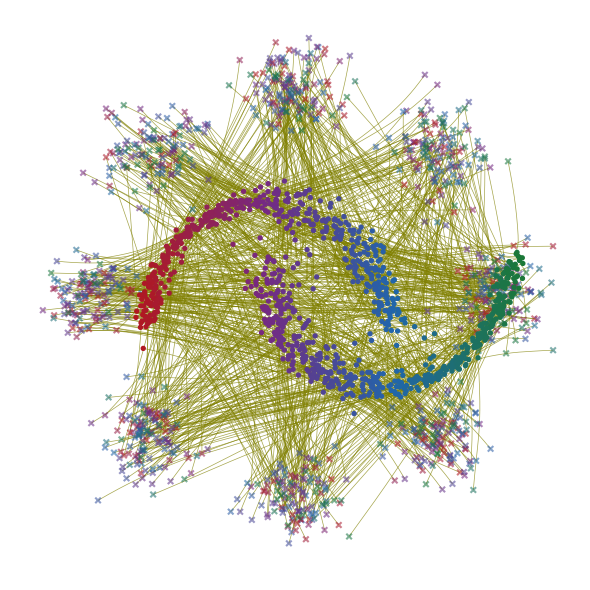

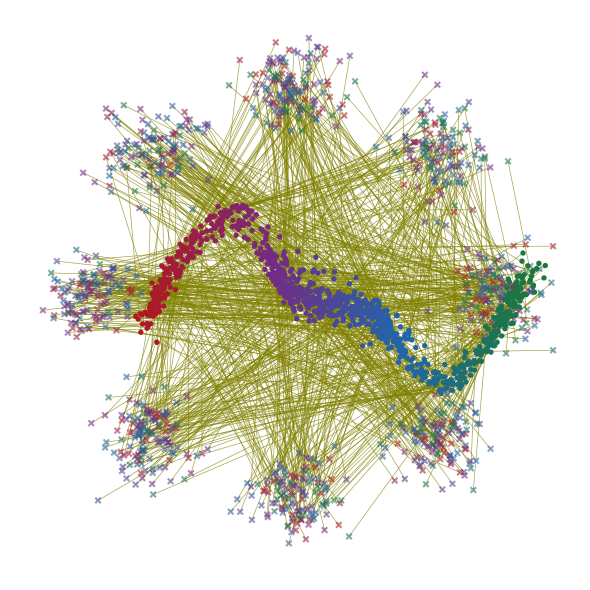

In [25]:
train_continuous('fm')

### Visualize the learned flows by OT (with an adaptive solver and with the single-step Euler method)

Number of parameters: 396.29K


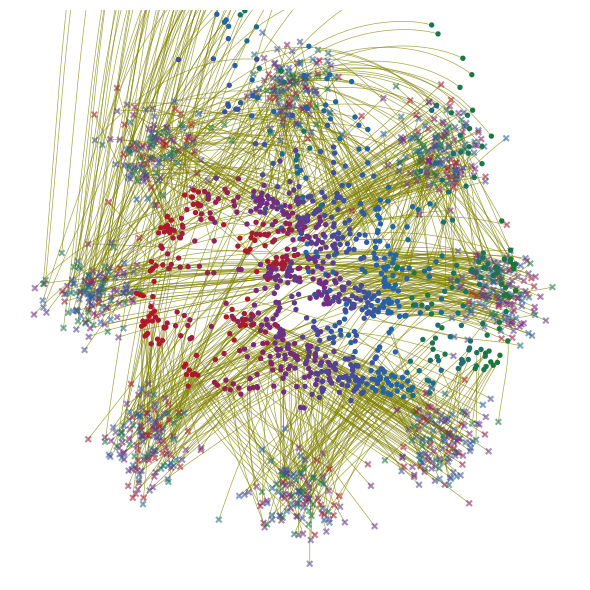

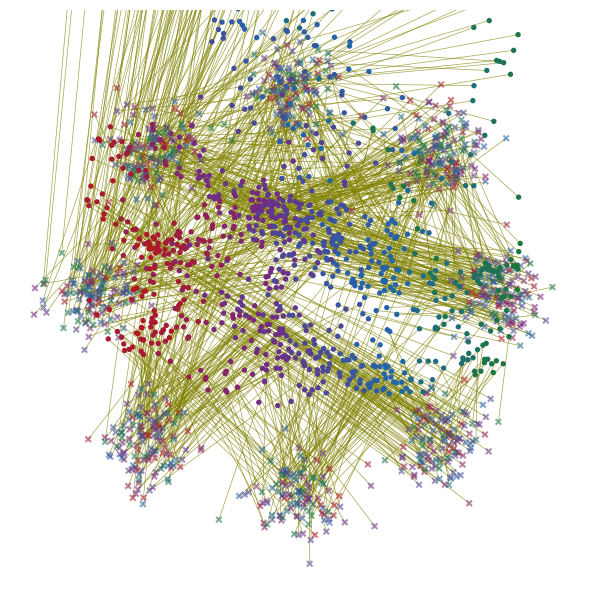

In [26]:
train_continuous('ot')

### ### Visualize the learned flows by our method C<sup>2</sup>OT (with an adaptive solver and with the single-step Euler method)

Number of parameters: 396.29K


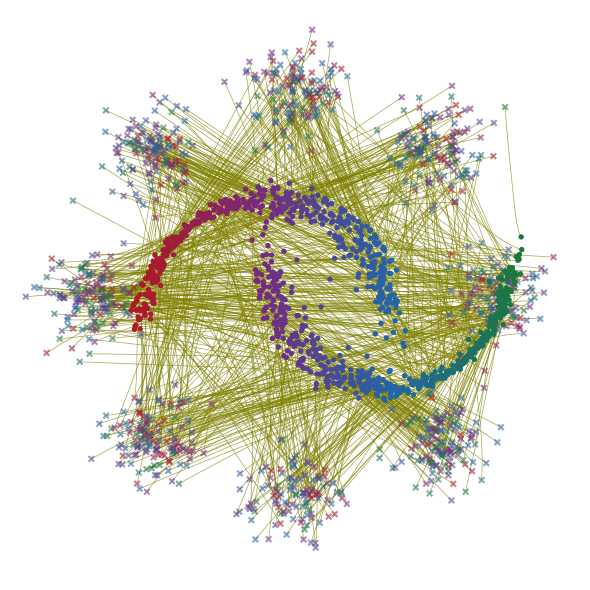

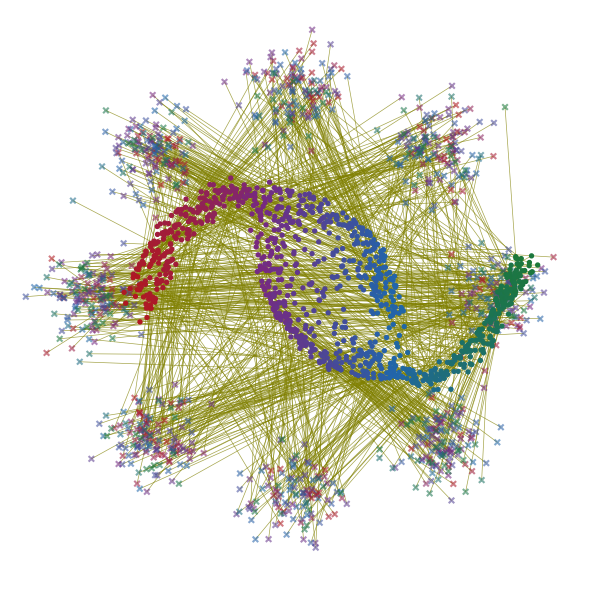

In [27]:
train_continuous('c2ot')

## Conclusion

We have demonstrated that C<sup>2</sup>OT is a promising method for conditional flow-based generation. It combines the best of both worlds -- the unskewed prior of FM and the straight flows of OT.
In the paper, we show that C<sup>2</sup>OT also works with continuous conditions (which is probably the more common use case) and in high-dimensional image generation. Have fun!